In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.simplefilter('ignore')
import seaborn as sns
sns.set_style("darkgrid", {'axes.grid' : True})

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
%matplotlib inline

import skimage

### Import Data

In [4]:
df = pd.read_csv('C:/Users/nevin/Downloads/Misc/Projects/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

### Data Exploration

In [5]:
print(df.shape)
pd.set_option('display.max_colwidth',-1)
df.head(4)

(50000, 2)


,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zom

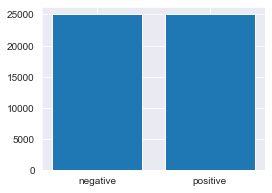

positive    25000
negative    25000
Name: sentiment, dtype: int64


In [6]:
# Number of poitive and negative reviews
dd = df['sentiment'].value_counts()
plt.figure(figsize=(4, 3))
plt.bar(x=np.array(['negative','positive']),height=dd.values)
plt.show()
print(df.sentiment.value_counts())

In [7]:
# Labels: each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.
df['sentiment'] = [1 if label =='positive' else 0 for label in df['sentiment']]
df['sentiment'].head(4)

0    1
1    1
2    1
3    0
Name: sentiment, dtype: int64

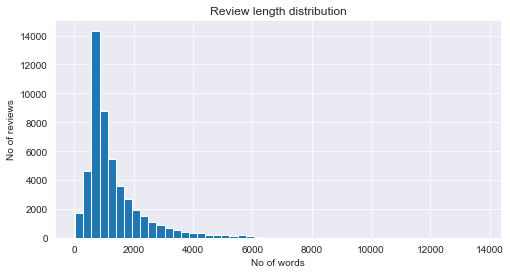

Biggest review has 13704 words


In [8]:
# Histogram of number of words per review
plt.figure(figsize=(8, 4))
plt.hist([len(sample) for sample in list(df['review'])], 50)
plt.xlabel('No of words')
plt.ylabel('No of reviews')
plt.title('Review length distribution')
plt.show()
print('Biggest review has', np.max([len(sample) for sample in list(df['review'])]),'words')

### Text feature extraction

We use **CountVectorizer** from the scikit-learn library to vectorize sentences. It Convert a collection of text documents to a matrix of token counts. This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix. If you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of feature selection then the number of features will be equal to the vocabulary size found by analyzing the data.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer() # not removing stop-words since we are gonna use tfidf
vect_texts = vectorizer.fit_transform(list(df['review']))
vocab = vectorizer.get_feature_names()
print('No of word in the vocabulary:', len(vocab))

No of word in the vocabulary: 101895


In [10]:
# The most common 50 words in the whole corpus
num_ngrams=50
tot_counts = vect_texts.sum(axis=0).tolist()[0]
word, tot_counts = zip(*[(word, count) for count, word in sorted(zip(tot_counts, vocab), reverse=True)])
words50 = word[:num_ngrams]
counts = tot_counts[:num_ngrams]
idx = np.arange(num_ngrams)

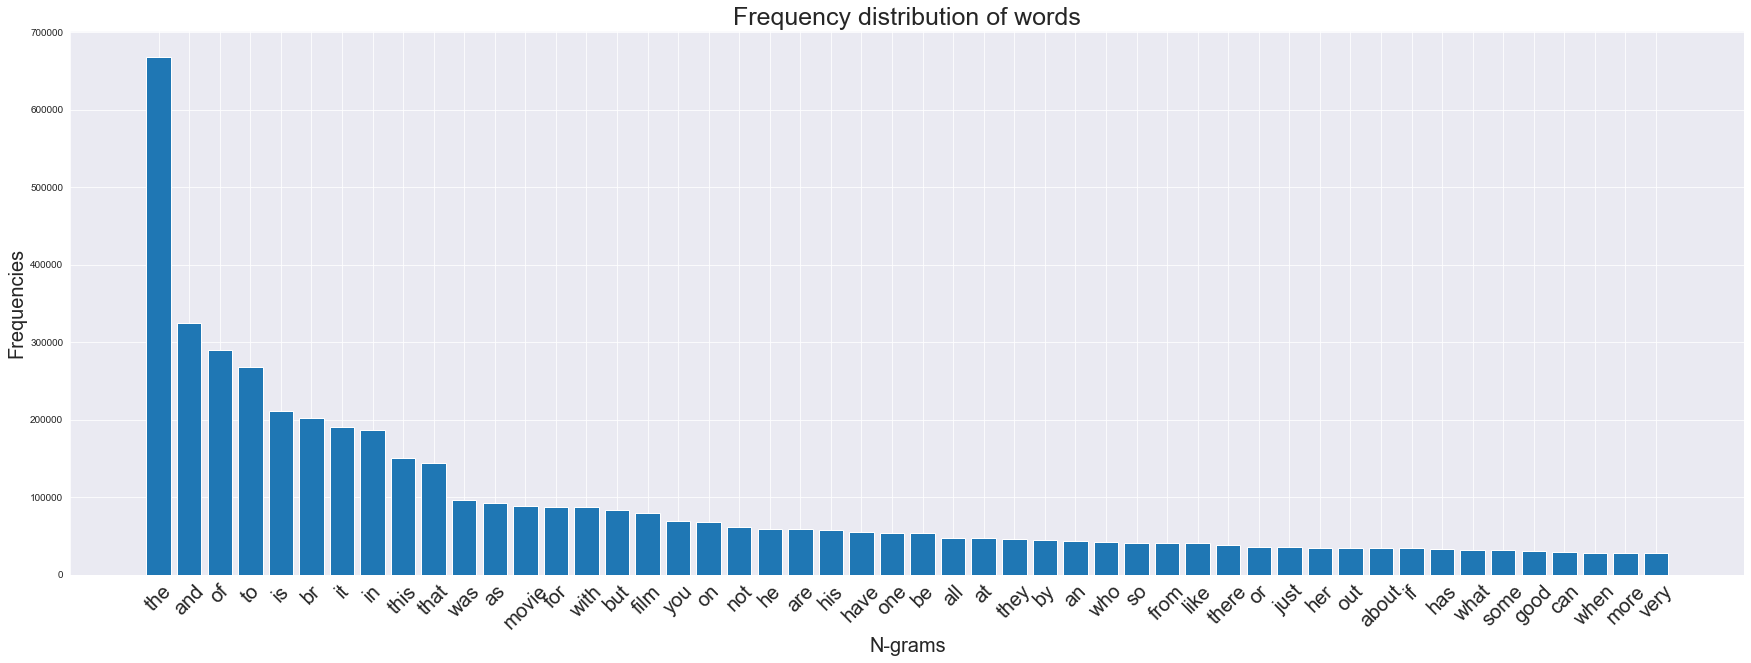

In [11]:
plt.figure(figsize=(30, 10))
plt.bar(idx, counts, width=0.8)
plt.xlabel('N-grams', fontsize=20)
plt.ylabel('Frequencies', fontsize=20)
plt.title('Frequency distribution of words', fontsize=25)
plt.xticks(idx, words50, rotation=45, fontsize=20)
plt.show()

As expected, the most frequent words in the corpus are the stop words. We usually exclude them in NLP tasks as they don't usually provide any valuable information about a particular document. However, we are not going to explicitly remove them in this task as TFIDF will take care of them by assigning them very small weights.

### Split data

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# y = (np.array(df['sentiment']))
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=13)
print("Train dataset shape: {0}, \nTest dataset shape: {1}".format(X_train.shape, X_test.shape))

Train dataset shape: (40000,), 
Test dataset shape: (10000,)


### TFIDF Transformation

Let's now prepare the data to feed into the model. For the data preparation step we will get bigrams and unigrams from the data and encode it using tf-idf. Then, we will select the top 20000 features from the vector of tokens using f_classif to get feature importance. We also discard features that occurs less than two times. <br>
Note that while we use the whole dataset to create the `tfidf_vectorizer`, only the training data is used to select the top 20000 features. We did this because in a practical scenario, the labels for the test set would not be available.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [15]:
%%time
kwargs = {
    'ngram_range' : (1, 2),
    'dtype' : 'int32',
    'strip_accents' : 'unicode',
    'decode_error' : 'replace',
    'analyzer' : 'word',
    'min_df' : 2,
}
# Learn Vocab from train texts and vectorize train and val sets
tfidf_vectorizer = TfidfVectorizer(**kwargs)
transformation = tfidf_vectorizer.fit(df['review'])
transformed_texts = transformation.transform(df['review'])
transformed_train = transformation.transform(X_train)
transformed_test = transformation.transform(X_test)

# Select best k features, with feature importance measured by f_classif
# Set k as 20000 or (if number of ngrams is less) number of ngrams   
TOP_K = 20000
selector = SelectKBest(f_classif, k=min(TOP_K, transformed_texts.shape[1]))
selector.fit(transformed_train, y_train)
X = selector.transform(transformed_texts).astype('float32').toarray()
X_train = selector.transform(transformed_train).astype('float32').toarray()
X_test = selector.transform(transformed_test).astype('float32').toarray()
print("Train dataset shape: {0}, \nTest dataset shape: {1}".format(X_train.shape, X_test.shape))

Train dataset shape: (40000, 20000), 
Test dataset shape: (10000, 20000)
Wall time: 1min 37s


### Model Architecture
We are going to build a deep neural network for predicting the sentiments. The number of layers, number of neurons per layer and learning rate can be adjusted using the parameters in the `create_model` function.

In this task, the input data consists of an array of word-probabilities. The labels to predict are either 0 or 1, i.e., it is a binary classification task. Therefore, we use *sigmoid** activation function in the final output layer and **binary_crossentropy** as the loss function.

In [16]:
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

In [17]:
def create_model(LAYERS = 2, UNITS = 64, DROPOUT_RATE = 0.2, LEARNING_RATE = 1e-3, batch_size=128):
    input_shape = X_train.shape[1:]

    model = keras.Sequential()
    # Applies Dropout to the input
    model.add(Dropout(rate=DROPOUT_RATE, input_shape=input_shape))
    for _ in range(LAYERS-1):
        model.add(Dense(units=UNITS, activation='relu'))
        model.add(Dropout(rate=DROPOUT_RATE))

    model.add(Dense(units=1, activation='sigmoid'))
    
    optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
    loss= 'binary_crossentropy'
    print(model.summary())
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])
    
    return model

### Cross-validation

In [18]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

Using TensorFlow backend.


In [19]:
# Create a model as a sklearn estimator
model = KerasClassifier(build_fn=create_model, epochs=6, batch_size=128)

In [20]:
%%time
# Cross-validation
# Define a series of parameters
params = dict(LAYERS = [2, 3, 4], UNITS = [64, 128, 256], DROPOUT_RATE = [0.1, 0.2, 0.3, 0.4],
              LEARNING_RATE = [0.1, 0.01, 0.001, 0.0001], batch_size=[64, 128, 256])
# Create a random search cv object and fit it to the data
random_search = RandomizedSearchCV(model, params, cv=3)
random_search_results = random_search.fit(X_train, y_train)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1280064   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/6
26666/26666 [====

Epoch 1/6
26667/26667 [==============================] - 10s 381us/sample - loss: 0.6701 - acc: 0.6498
Epoch 2/6
26667/26667 [==============================] - 9s 354us/sample - loss: 0.3760 - acc: 0.8719
Epoch 3/6
26667/26667 [==============================] - 10s 356us/sample - loss: 0.2357 - acc: 0.9094
Epoch 4/6
26667/26667 [==============================] - 10s 357us/sample - loss: 0.2008 - acc: 0.9219
Epoch 5/6
26667/26667 [==============================] - 9s 355us/sample - loss: 0.1710 - acc: 0.9368s - l
Epoch 6/6
13333/13333 [==============================] - 1s 85us/sample - loss: 0.1812 - acc: 0.9294
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_14 (Dropout)         (None, 20000)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               2560128   
_____________________________

Epoch 1/6
26666/26666 [==============================] - 13s 486us/sample - loss: 0.2822 - acc: 0.8894 - loss: 0.2832 - acc: 0.88
Epoch 2/6
26666/26666 [==============================] - 12s 468us/sample - loss: 0.1162 - acc: 0.9571
Epoch 3/6
26666/26666 [==============================] - 12s 468us/sample - loss: 0.0686 - acc: 0.9762
Epoch 4/6
26666/26666 [==============================] - 12s 461us/sample - loss: 0.0444 - acc: 0.9841
Epoch 5/6
26666/26666 [==============================] - 12s 460us/sample - loss: 0.0291 - acc: 0.9897TA: 0s - loss: 0.0290 - acc: 0
Epoch 6/6
13334/13334 [==============================] - 2s 116us/sample - loss: 0.3341 - acc: 0.9187
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_27 (Dropout)         (None, 20000)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 256

13333/13333 [==============================] - 1s 92us/sample - loss: 0.1810 - acc: 0.9274
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_39 (Dropout)         (None, 20000)             0         
_________________________________________________________________
dense_39 (Dense)             (None, 128)               2560128   
_________________________________________________________________
dropout_40 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_41 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 129       
Total params: 2,576,769
Trai

Epoch 1/6
26666/26666 [==============================] - 13s 498us/sample - loss: 0.3879 - acc: 0.8560
Epoch 2/6
26666/26666 [==============================] - 12s 463us/sample - loss: 0.2952 - acc: 0.8966
Epoch 3/6
26666/26666 [==============================] - 12s 458us/sample - loss: 0.5414 - acc: 0.8468
Epoch 4/6
26666/26666 [==============================] - 12s 453us/sample - loss: 0.5057 - acc: 0.9026
Epoch 5/6
26666/26666 [==============================] - 12s 451us/sample - loss: 2.3466 - acc: 0.9006
Epoch 6/6
13334/13334 [==============================] - 2s 120us/sample - loss: 0.4557 - acc: 0.8950
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_55 (Dropout)         (None, 20000)             0         
_________________________________________________________________
dense_55 (Dense)             (None, 128)               2560128   
______________________________

26667/26667 [==============================] - 9s 328us/sample - loss: 0.2544 - acc: 0.8944
Epoch 2/6
26667/26667 [==============================] - 8s 304us/sample - loss: 0.0982 - acc: 0.9632
Epoch 3/6
26667/26667 [==============================] - 8s 306us/sample - loss: 0.0563 - acc: 0.9780
Epoch 4/6
26667/26667 [==============================] - 8s 306us/sample - loss: 0.0372 - acc: 0.9861
Epoch 5/6
26667/26667 [==============================] - 8s 307us/sample - loss: 0.0287 - acc: 0.9900
Epoch 6/6
13333/13333 [==============================] - 1s 89us/sample - loss: 0.3836 - acc: 0.9132
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_69 (Dropout)         (None, 20000)             0         
_________________________________________________________________
dense_69 (Dense)             (None, 64)                1280064   
______________________________________________

Epoch 1/6
26666/26666 [==============================] - 11s 409us/sample - loss: 0.4245 - acc: 0.8112
Epoch 2/6
26666/26666 [==============================] - 10s 363us/sample - loss: 0.2917 - acc: 0.8847
Epoch 3/6
26666/26666 [==============================] - 10s 361us/sample - loss: 0.2846 - acc: 0.8841
Epoch 4/6
26666/26666 [==============================] - 10s 384us/sample - loss: 0.2610 - acc: 0.8905
Epoch 5/6
26666/26666 [==============================] - 10s 389us/sample - loss: 0.2475 - acc: 0.8965
Epoch 6/6
13334/13334 [==============================] - 1s 97us/sample - loss: 0.2005 - acc: 0.9255
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_81 (Dropout)         (None, 20000)             0         
_________________________________________________________________
dense_81 (Dense)             (None, 128)               2560128   
_______________________________

In [21]:
print("Best accuracy of",random_search_results.best_score_, "for parameters:", random_search_results.best_params_)

Best accuracy of 0.9314999580383301 for parameters: {'batch_size': 128, 'UNITS': 128, 'LEARNING_RATE': 0.0001, 'LAYERS': 4, 'DROPOUT_RATE': 0.4}


### Training using the best model

In [22]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [23]:
# Instantiate an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
# Instantiate a model checkpoint callback
model_save = ModelCheckpoint('best_model.hdf5',save_best_only=True)

callbacks = [early_stopping, model_save]

In [24]:
history=random_search_results.best_estimator_.fit(X_train, y_train, batch_size=64, epochs=100, 
                                                  validation_data=(X_test, y_test), verbose=1, callbacks=callbacks)

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_91 (Dropout)         (None, 20000)             0         
_________________________________________________________________
dense_91 (Dense)             (None, 128)               2560128   
_________________________________________________________________
dropout_92 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_92 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_93 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_93 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_94 (Dropout)         (None, 128)             

### Evaluation of model on test set

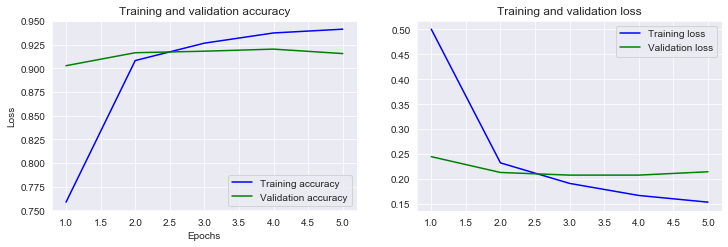

In [25]:
# Let's plot training and validation accuracy as well as loss.
def plot_history(history):
    accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1,len(accuracy) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 3.5))
    
    # Plot accuracy  
    ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
    ax1.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
    ax1.set_title('Training and validation accuracy')
    ax1.set(xlabel='Epochs', ylabel='Accuracy')
    ax1.legend()
    
    # Plot loss
    ax2.plot(epochs, loss, 'b', label='Training loss')
    ax2.plot(epochs, val_loss, 'g', label='Validation loss')
    ax2.set_title('Training and validation loss')
    ax1.set(xlabel='Epochs', ylabel='Loss')
    ax2.legend()

plot_history(history)

We can see that after a certain number of epochs, the model starts to overfit. The `ModelCheckpoint` callback we used, helps us choose the weights which gave the best results on the testing set before the model starts to overfit.

In [26]:
# Creating an instance of the best model as found by Randomized CV
best_model=create_model(**random_search_results.best_params_)

# Loads the weights
best_model.load_weights('best_model.hdf5')

# Re-evaluate the model
loss,acc = best_model.evaluate(X_test, y_test, verbose=1)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

# Predicted classes and probabilities
pred=best_model.predict_classes(X_test)
pred_prob=best_model.predict(X_test)

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_95 (Dropout)         (None, 20000)             0         
_________________________________________________________________
dense_95 (Dense)             (None, 128)               2560128   
_________________________________________________________________
dropout_96 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_96 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_97 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_97 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_98 (Dropout)         (None, 128)             

### Prediction Examples

#### True Positive

In [27]:
i=6
index,=np.where((X == X_test[i]).all(axis=1))[0]
print(df['review'][index])
print('--')
print('Actual sentiment:', ('positive' if df['sentiment'][index]==1 else 'negative'))
print('Predicted sentiment:', ('positive' if pred[i][0]==1 else 'negative'), 
      'with probability', (pred_prob[i][0] if pred[i][0]==1 else (1-pred_prob[i][0])))

No. I'm not kidding with this one. He was a guest reviewer for Entertainment Weekly and gave this movie positive marks. And who can blame him? This is a charming, upbeat, and rather funny Disney movie. Who doesn't love kittens? The music in Ev'rybody Wants To Be A Cat is jamming. It makes me want to snap my fingers or something. Only years later when Cats Don't Dance came out have I seen a movie that was that musically fun. What Aristocats lacks in animation and story, it makes up for in charm. Plus, everything moves at a relaxed pace, and even the villain isn't all that scary. It's perfect for the younger set while not being so sappy that adults can't like it. If Snoop was here, I'm sure he would say the same thing. Yeah. Dig those CRAZY cats, man.
--
Actual sentiment: positive
Predicted sentiment: positive with probability 0.9316584


#### True Negative

In [28]:
i=1
index,=np.where((X == X_test[i]).all(axis=1))[0]
print(df['review'][index])
print('--')
print('Actual sentiment:', ('positive' if df['sentiment'][index]==1 else 'negative'))
print('Predicted sentiment:', ('positive' if pred[i][0]==1 else 'negative'), 
      'with probability', (pred_prob[i][0] if pred[i][0]==1 else (1-pred_prob[i][0])))

The summary provided by my cable TV guide made it sound a lot more interesting than it actually is. "Slaughterhouse Rock" is by far the worst horror film that I have ever seen, a title previously held by "Urban Legends: Final Cut". From its opening scene I could tell it's going to be really bad, but I was so bored that I couldn't care less. This film contains laughable acting, especially by the guy who's tormented in his dreams, incredible as in not credible plot twists, and some of the crappiest music I've heard, and I'm living in a period when the likes of Britney Spears and Nsync dominate the air waves. The biggest problem with "Slaughterhouse Rock" is that it's not funny. One would a film as dull and boring and so NOT scary as this would try to spice things up a bit with a few funny one-liners here and there, but no. We have Tormented Guy's self-centered friend trying to be funny, but came across as annoying instead. (spoiler) And please, do tell me, who in this crazy world is insa

#### False Positive

In [29]:
i=np.argmax(np.reshape(pred,(10000,))-y_test)
index,=np.where((X == X_test[i]).all(axis=1))[0]
print(df['review'][index])
print('--')
print('Actual sentiment:', ('positive' if df['sentiment'][index]==1 else 'negative'))
print('Predicted sentiment:', ('positive' if pred[i][0]==1 else 'negative'), 
      'with probability', (pred_prob[i][0] if pred[i][0]==1 else (1-pred_prob[i][0])))

On the pure theatrical side, Last Stand was great, as the reenactments and soundtrack are very entertaining, but there are better accounts of this battle found elsewhere that, while not as long or as flashy, are far more historically comprehensive.<br /><br />Certain little details, such as the misuse of the word "hoplon" for the Greek hoplite shield and the mispronounciations of various names and words, really ate at me.<br /><br />My guess would be, that because "Last Stand of the 300" was aired the eve of the theatrical release of "300", the History Channel was only trying to ride the coattails of the movie's hype.<br /><br />If you're looking for a depiction that's historically accurate in all respects possible, you'd have better luck elsewhere.
--
Actual sentiment: negative
Predicted sentiment: positive with probability 0.7180848


#### False Negative

In [30]:
i=np.argmin(np.reshape(pred,(10000,))-y_test)
index,=np.where((X == X_test[i]).all(axis=1))[0]
print(df['review'][index])
print('--')
print('Actual sentiment:', ('positive' if df['sentiment'][index]==1 else 'negative'))
print('Predicted sentiment:', ('positive' if pred[i][0]==1 else 'negative'), 
      'with probability', (pred_prob[i][0] if pred[i][0]==1 else (1-pred_prob[i][0])))

When I heard about "Hammerhead" being released on DVD and finally found it at my local DVD store, I thought "well, just another cheap monster movie from Nu Image". Those guys around Boaz Davidson and Avi Lerner produced cheap but very entertaining B - Pictures in the past few months but also some very disappointing movies. So I didn't expect much, especially after having watched the rather disappointing "Shark Zone" just a few days before. But "Hammerhead" turned out to be an excellent revival of the 1950s monster movies. We have a mad scientist, a group of people in a dangerous situation, screaming women and damsels in distress, man-eating plants and of course we have the creature, a huge mutant mix between a man and a hammerhead shark. Everything you need for an entertaining monster movie. The only thing missing are graphic sex scenes and nudity which you expect in movies of this kind, but since the movie was made for TV it's understandable why these scenes are missing. And it doesn'